# DAT 19: Homework 2 Assignment

## Instructions

For Homework 2, we will build on the work we did with the Titanic dataset in Homework 1. In this assignment, we will build a logistic regression model to predict passenger survival.

Please do all your analysis to answer the questions below in this Jupyter notebook. Show your work.

**Please submit your completed notebook by 6:00PM on Monday, January 11.**

## About the Data

```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.
```

## Getting Started

**Load libraries and dataset**

In [58]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
# bring dataset in as a pandas dataframe
df = pd.DataFrame.from_csv('https://raw.githubusercontent.com/colby-schrauth/DAT_SF_19/master/data/titanic.csv',
                           header=0, sep=',', index_col=False)

test_df = pd.DataFrame.from_csv('https://raw.githubusercontent.com/colby-schrauth/DAT_SF_19/master/hw-assignments/titanic-test.csv',
                           header=0, sep=',', index_col=False)

In [60]:
# print the first 5 rows to make sure I've imported the dataset properly
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [61]:
# print the last 5 rows to make sure I've imported the dataset properly  
df.tail(5)  

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,NaN,Q


In [62]:
# scan the attributes of the dataframe to obtain an initial understanding of what we're working with
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Data Preparation**

In [63]:
# create a reference for the column names for easy recall
print list(df.columns.values)

# convert 'Sex' column to binary, and place values in two new columns: 'Male', 'Female'
df['Male'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df['Female'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

test_df['Male'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test_df['Female'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [64]:
# check our work - print the first 5 rows to make sure I've parsed correctly
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Male,Female
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,0


In [65]:
# check out work - make sure every row has been accounted for
print df.Sex.value_counts()
print df.Male.value_counts()
print df.Female.value_counts()

male      577
female    314
Name: Sex, dtype: int64
1    577
0    314
Name: Male, dtype: int64
0    577
1    314
Name: Female, dtype: int64


In [66]:
# identify the unique values in 'Embarked' and their associated frequencies
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [67]:
# fill in Embarked nulls with most common embarkment
df['Embarked'].fillna('S', inplace=True)
test_df['Embarked'].fillna('S', inplace=True)

# check to make sure there are no more null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Male           891 non-null int64
Female         891 non-null int64
dtypes: float64(2), int64(7), object(5)
memory usage: 104.4+ KB


In [68]:
# break apart 'Embarked' column into binary peices, and place them in three newly created colums ('S', 'C', 'Q')
df['EmbarkedS'] = df['Embarked'].map( {'S': 1, 'C': 0, 'Q': 0}).astype(int)
df['EmbarkedC'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 0}).astype(int)
df['EmbarkedQ'] = df['Embarked'].map( {'S': 0, 'C': 0, 'Q': 1}).astype(int)

test_df['EmbarkedS'] = df['Embarked'].map( {'S': 1, 'C': 0, 'Q': 0}).astype(int)
test_df['EmbarkedC'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 0}).astype(int)
test_df['EmbarkedQ'] = df['Embarked'].map( {'S': 0, 'C': 0, 'Q': 1}).astype(int)

In [69]:
# check the new columns
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Male,Female,EmbarkedS,EmbarkedC,EmbarkedQ
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,1,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,1,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,0,1,0,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,0,0,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,1,0,1,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S,1,0,1,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S,0,1,1,0,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C,0,1,0,1,0


In [70]:
# fill in missing age values with the median for each gender, in each class
# start by creating an empty numpy matrix
median_ages = np.zeros((2,3))
median_ages

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [71]:
# fill the median_ages matrix with the value
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df[(df['Male'] == i) & \
                              (df['Pclass'] == j+1)]['Age'].dropna().median()
        
median_ages

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

In [72]:
# create a new colume titled 'AgeFill', which is equal to 'Age'
df['AgeFill'] = df['Age']
test_df['AgeFill'] = test_df['Age']

# check my work
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Male,Female,EmbarkedS,EmbarkedC,EmbarkedQ,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,0,1,0,0,22
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,1,0,1,0,38
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,0,0,26
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,1,1,0,0,35
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,0,1,0,0,35


In [73]:
# pull back a handful of entries where the 'Age' value is null
df[ df['Age'].isnull() ][['Male', 'Female', 'Pclass','Age','AgeFill']].head(10)
test_df[ test_df['Age'].isnull() ][['Male', 'Female', 'Pclass','Age','AgeFill']].head(10)

,Male,Female,Pclass,Age,AgeFill
10,0,1,3,NaN,NaN
22,0,1,1,NaN,NaN
29,1,0,3,NaN,NaN
33,1,0,3,NaN,NaN
36,1,0,3,NaN,NaN
39,0,1,3,NaN,NaN
41,0,1,1,NaN,NaN
47,0,1,3,NaN,NaN
54,1,0,2,NaN,NaN
58,0,1,3,NaN,NaN


In [74]:
# fill the 'AgeFill' column with the values discovered, and stored in the median_ages matrix
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[ (df.Age.isnull()) & (df.Male == i) & (df.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]
        
for i in range(0, 2):
    for j in range(0, 3):
        test_df.loc[ (test_df.Age.isnull()) & (test_df.Male == i) & (test_df.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]
        
# check my work
df[ df['Age'].isnull() ][['Male', 'Female', 'Pclass','Age','AgeFill']].head(10)

,Male,Female,Pclass,Age,AgeFill
5,1,0,3,NaN,25.0
17,1,0,2,NaN,30.0
19,0,1,3,NaN,21.5
26,1,0,3,NaN,25.0
28,0,1,3,NaN,21.5
29,1,0,3,NaN,25.0
31,0,1,1,NaN,35.0
32,0,1,3,NaN,21.5
36,1,0,3,NaN,25.0
42,1,0,3,NaN,25.0


In [75]:
# create a new column 'AgeIsNull', which reminds us of whether or not the original 'Age' column was null
df['AgeIsNull'] = pd.isnull(df.Age).astype(int)
test_df['AgeIsNull'] = pd.isnull(test_df.Age).astype(int)

# check my work
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Male,Female,EmbarkedS,EmbarkedC,EmbarkedQ,AgeFill,AgeIsNull
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,0,1,0,0,22,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,1,0,1,0,38,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,0,0,26,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,1,1,0,0,35,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,0,1,0,0,35,0


**Feature Engineering**

In [76]:
# create new feature called 'FamilySize' equal to # of siblings + # of parents
df['FamilySize'] = df['SibSp'] + df['Parch']
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']

In [77]:
# creata new feature called 'Age*Class' equal to Age * Pclass
df['Age*Class'] = df.AgeFill * df.Pclass
test_df['Age*Class'] = test_df.AgeFill * test_df.Pclass

# check my work
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Male,Female,EmbarkedS,EmbarkedC,EmbarkedQ,AgeFill,AgeIsNull,FamilySize,Age*Class
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,S,1,0,1,0,0,22,0,1,66
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,C,0,1,0,1,0,38,0,1,38
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,...,S,0,1,1,0,0,26,0,0,78
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,S,0,1,1,0,0,35,0,1,35
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,S,1,0,1,0,0,35,0,0,105


**Machine Learning Preparation** 

In [78]:
# check for object data types, as these will columns will be eliminated
df.dtypes
df.dtypes[df.dtypes.map(lambda x: x=='object')]

test_df.dtypes
test_df.dtypes[test_df.dtypes.map(lambda x: x=='object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [79]:
# drop all columns that we will not use
df = df.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis=1)
test_df = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis=1)

# check my work
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Male           418 non-null int64
Female         418 non-null int64
EmbarkedS      418 non-null int64
EmbarkedC      418 non-null int64
EmbarkedQ      418 non-null int64
AgeFill        418 non-null float64
AgeIsNull      418 non-null int64
FamilySize     418 non-null int64
Age*Class      418 non-null float64
dtypes: float64(3), int64(11)
memory usage: 49.0 KB


In [80]:
# convert back to a numpy array
train_data = df.values
train_data

array([[  0. ,   3. ,   1. , ...,   0. ,   1. ,  66. ],
       [  1. ,   1. ,   1. , ...,   0. ,   1. ,  38. ],
       [  1. ,   3. ,   0. , ...,   0. ,   0. ,  78. ],
       ..., 
       [  0. ,   3. ,   1. , ...,   1. ,   3. ,  64.5],
       [  1. ,   1. ,   0. , ...,   0. ,   0. ,  26. ],
       [  0. ,   3. ,   0. , ...,   0. ,   0. ,  96. ]])

**1) Create a logistic regression model on the Titanic dataset to predict the survival of passengers. Show your model output. Include coefficient values.**

Please see code below

**2) Which features are predictive for this logistic regression? Explain your thinking. Do not simply cite model statistics.**

I believe that gender, age and passenger class are going to have the highest predictive power. At first thought, this stems from domain knowledge about the Titanic story and the individuals that were most likely to survive

**3) Implement cross-validation for your logistic regression model. Select the number of folds. Explain your choice.**

I selected five folds. I'm looking for an 80-20 split in each cross-validation instance, which leaves me with 5 folds

In [81]:
# instantiate the logistic regression model
model_lr = LogisticRegression(C=1)

In [82]:
# split features from target
features = df.drop('Survived',axis=1)
target = df.Survived

In [83]:
# run the model, and get an average score for accuracy
cross_val_score(model_lr,features,target,cv=5).mean()

0.79801424717540725

In [84]:
# test for different c values using a for loop
c_range = range(1,31)
c_scores = []

for i in range(1,31):
    model_lr = LogisticRegression(C=i)
    features = df.drop('Survived',axis=1)
    target = df.Survived
    c_scores.append(cross_val_score(model_lr,features,target,cv=5).mean())

print c_scores

[0.79801424717540725, 0.80025516111677941, 0.79913149468381828, 0.79800155118099347, 0.79800155118099347, 0.7991251466866115, 0.8002487421922293, 0.8002487421922293, 0.8002487421922293, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422, 0.80137868569505422]


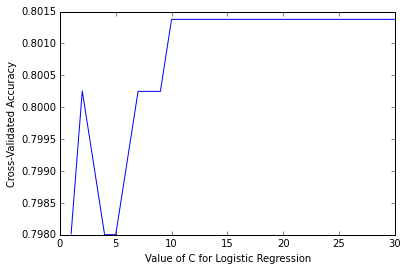

In [85]:
# plot the value of C for Logistic Regression (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(c_range, c_scores)
plt.xlabel('Value of C for Logistic Regression')
plt.ylabel('Cross-Validated Accuracy')

In [86]:
# re-instantiate the model with an updated value for C
model_lr = LogisticRegression(C=10).fit(features, target)

# run the model, and get an average score for accuracy
cross_val_score(model_lr,features,target,cv=5).mean()

0.80137868569505422

In [87]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = pd.DataFrame(df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(model_lr.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Pclass,-0.985276
1,SibSp,-0.207900
2,Parch,0.054064
3,Fare,0.001934
4,Male,-0.337009
5,Female,2.348000
6,EmbarkedS,0.409120
7,EmbarkedC,0.807933
8,EmbarkedQ,0.793938
9,AgeFill,-0.031764


In [100]:
# Normalize our feature set
n_features = StandardScaler().fit_transform(features)
n_features = pd.DataFrame(n_features, columns=features.columns)
n_features.head(5)

,Pclass,SibSp,Parch,Fare,Male,Female,EmbarkedS,EmbarkedC,EmbarkedQ,AgeFill,AgeIsNull,FamilySize,Age*Class
0,0.827377,0.432793,-0.473674,-0.502445,0.737695,-0.737695,0.615838,-0.482043,-0.307562,-0.534891,-0.497895,0.059160,0.107998
1,-1.566107,0.432793,-0.473674,0.786845,-1.355574,1.355574,-1.623803,2.074505,-0.307562,0.668392,-0.497895,0.059160,-0.785303
2,0.827377,-0.474545,-0.473674,-0.488854,-1.355574,1.355574,0.615838,-0.482043,-0.307562,-0.234070,-0.497895,-0.560975,0.490841
3,-1.566107,0.432793,-0.473674,0.420730,-1.355574,1.355574,0.615838,-0.482043,-0.307562,0.442776,-0.497895,0.059160,-0.881014
4,0.827377,-0.474545,-0.473674,-0.486337,0.737695,-0.737695,0.615838,-0.482043,-0.307562,0.442776,-0.497895,-0.560975,1.352239


In [101]:
model_lr = LogisticRegression(C=10).fit(n_features, target)

In [102]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = pd.DataFrame(df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(model_lr.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Pclass,-0.866140
1,SibSp,-0.274301
2,Parch,0.010065
3,Fare,0.088391
4,Male,-0.643983
5,Female,0.643983
6,EmbarkedS,-0.097479
7,EmbarkedC,0.073085
8,EmbarkedQ,0.053159
9,AgeFill,-0.460170


In [112]:
#n_features = n_features.drop(["Parch", "Fare", "EmbarkedS", "EmbarkedC", "EmbarkedQ", "AgeIsNull", "Age*Class"], axis=1)
n_features

model_lr = LogisticRegression(C=10).fit(n_features, target)

In [113]:
# fill in missing 'Fare' value within the Test dataset
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# check my work
test_df[ test_df['Fare'].isnull() ][['Male', 'Female', 'Pclass','Fare']].head(10)

,Male,Female,Pclass,Fare


**4) In the hw-assignments director on the class github repo, there is a file called titanic-test.csv. What does your logistic regression model predict for these previously unseen (i.e. out of sample) passengers?**

This returned a score of .5837, which is not my highest score as I've submitted to this project in the past, making me believe I did something wrong - haha!

In [114]:
# run the test dataset through standardization and predict the outcome
X_test = test_df.drop(["PassengerId", "Parch", "Fare", "EmbarkedS", "EmbarkedC", "EmbarkedQ", "AgeIsNull", "Age*Class"], axis=1).copy()
y_features = StandardScaler().fit_transform(X_test)
X_test = y_features
Y_pred = model_lr.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)